This will contain code that only have working and possible codes. No comment to little comment in this file.

In [1]:
import pandas as pd
import logging
import os
logging.getLogger().setLevel(logging.INFO)

donation_facilities_url = "https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/donations_facility.csv"
donation_state_url = "https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/donations_state.csv"
newdonors_facility_url = "https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/newdonors_facility.csv"
newdonors_state_url = "https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/newdonors_state.csv"

def get_data_url(url_link):
    try:
        data = pd.read_csv(url_link) # , parse_dates=['date'], index_col='date'
        logging.info(f"Getting data from {url_link}")
        return data
    except Exception as e:
        logging.error(f"Unexpected error fetching data from {url_link}: {e}")
        return None

donation_facilities = get_data_url(donation_facilities_url)
donation_state = get_data_url(donation_state_url)
newdonors_facility = get_data_url(newdonors_facility_url)
newdonors_state = get_data_url(newdonors_state_url)

blood_donation_retention = pd.read_parquet("https://dub.sh/ds-data-granular") # In this parquet, there is no date



INFO:root:Getting data from https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/donations_facility.csv
INFO:root:Getting data from https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/donations_state.csv
INFO:root:Getting data from https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/newdonors_facility.csv
INFO:root:Getting data from https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/newdonors_state.csv


Store in csv file from the data

In [2]:
def append_data(data, file_path):
    if os.path.exists(file_path):
        existing_data = pd.read_csv(file_path)
        updated_data = pd.merge(existing_data, data, how='outer', indicator=True).query('_merge == "right_only"').drop('_merge', axis=1)
    else:
        updated_data = data
        logging.info(f"File not exist. Create new file")

    updated_data.to_csv(file_path, index=False, mode='a', header=not os.path.exists(file_path))
    logging.info(f"Data appended to {file_path}.")

    return pd.read_csv(file_path)

donation_facilities_updated = append_data(donation_facilities, "donation_facilities.csv")
donation_state_updated = append_data(donation_state, "donation_state.csv")
newdonors_facility_updated = append_data(newdonors_facility,"newdonors_facility.csv")
newdonors_state_updated = append_data(newdonors_state, "newdonors_state.csv")
blood_donation_retention_updated = append_data(blood_donation_retention, "blood_donation_retention.csv")

INFO:root:Data appended to donation_facilities.csv.
INFO:root:Data appended to donation_state.csv.
INFO:root:Data appended to newdonors_facility.csv.
INFO:root:Data appended to newdonors_state.csv.
INFO:root:Data appended to blood_donation_retention.csv.


Get the information of each dataset.

In [3]:
print(donation_facilities_updated.info()) #145090 is the original count on 21/01/2024 #145112 as of 23/01/2024
print(donation_state_updated.info())
print(newdonors_facility_updated.info())
print(newdonors_state_updated.info())
print(blood_donation_retention_updated.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145146 entries, 0 to 145145
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   date                     145146 non-null  object
 1   hospital                 145146 non-null  object
 2   daily                    145146 non-null  int64 
 3   blood_a                  145146 non-null  int64 
 4   blood_b                  145146 non-null  int64 
 5   blood_o                  145146 non-null  int64 
 6   blood_ab                 145146 non-null  int64 
 7   location_centre          145146 non-null  int64 
 8   location_mobile          145146 non-null  int64 
 9   type_wholeblood          145146 non-null  int64 
 10  type_apheresis_platelet  145146 non-null  int64 
 11  type_apheresis_plasma    145146 non-null  int64 
 12  type_other               145146 non-null  int64 
 13  social_civilian          145146 non-null  int64 
 14  social_student      

Change 4 dataset into time series dataset where date will be the DateTimeIndex

In [4]:
def change_dataframe_timeindex(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'],errors='coerce')
    dataframe = dataframe.set_index('date', inplace=True)


change_dataframe_timeindex(donation_facilities_updated)
change_dataframe_timeindex(donation_state_updated)
change_dataframe_timeindex(newdonors_facility_updated)
change_dataframe_timeindex(newdonors_state_updated)

Plot the total donation from each blood type

2006-01-01 00:00:00
2024-01-23 00:00:00


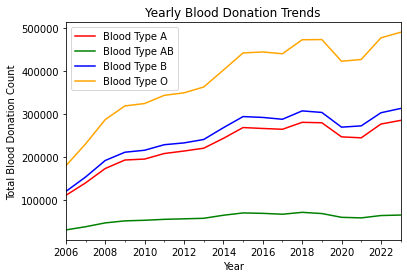

In [5]:
import matplotlib.pyplot as plt
oldest_date = donation_state_updated.index.min()
newest_date = donation_state_updated.index.max()
print(oldest_date)
print(newest_date)

# Use .loc to select a range of dates
donation_state_updated_resampled = donation_state_updated.resample('Y').sum()
donation_state_updated_resampled = donation_state_updated_resampled.loc[oldest_date:newest_date]

# Plotting
donation_state_updated_resampled['blood_a'].plot(label='Blood Type A', color='red')
donation_state_updated_resampled['blood_ab'].plot(label='Blood Type AB', color='green')
donation_state_updated_resampled['blood_b'].plot(label='Blood Type B', color='blue')
donation_state_updated_resampled['blood_o'].plot(label='Blood Type O', color='orange')

plt.title("Yearly Blood Donation Trends")
plt.xlabel("Year")
plt.ylabel("Total Blood Donation Count")
plt.legend()
plt.show()


Plot blood retention of each age group category

['17-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', 'other']
1899
2024


C:\Users\Irfan Syafi\AppData\Local\Temp\ipykernel_13700\1883400315.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blood_donation_grouped = blood_donation_retention_updated.groupby(by=['age_group']).count()


<Figure size 1152x576 with 0 Axes>

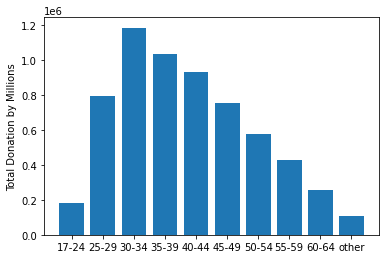

In [6]:
import matplotlib.pyplot as plt

blood_donation_retention_updated['age'] = int(newest_date.year) - blood_donation_retention_updated['birth_date']
plt.figure(figsize=(16,8))
idcount = blood_donation_retention_updated['donor_id'].value_counts()
oldest = blood_donation_retention_updated['birth_date'].min()
youngest = blood_donation_retention_updated['birth_date'].max()
age_group_list = newdonors_state_updated.columns[1:11].to_list()
#print(idcount)
print(age_group_list)
print(oldest)
print(youngest)

bins = [16, 24, 29, 34, 39, 44, 49, 54, 59, 64, 150]


blood_donation_retention_updated['age_group'] = pd.cut(blood_donation_retention_updated['age'], bins=bins, labels=age_group_list, right=False)

blood_donation_grouped = blood_donation_retention_updated.groupby(by=['age_group']).count()


fig, ax = plt.subplots()
ax.bar(blood_donation_grouped.index,pd.to_numeric(blood_donation_grouped['age']))
ax.set_ylabel('Total Donation by Millions')
plt.show()


Average per person that revisit for blood donation

In [7]:
donor_grouped = blood_donation_retention_updated.groupby(by = ['donor_id']).count()
donor_grouped.head(10)
average_per_person = donor_grouped['visit_date'].mean()
print(average_per_person)

2.782103909421483
